# Calculation of isoprenol concentrations for different strain designs and generation of omics data for the wild type strain

Tested using biodesign_3.7 kernel on the jprime.lbl.gov server. It uses the cplex library for running the MOMA optimization

#### The two files that are necessary for the notebook to run are:
   - A modified E. coli model with the isopentenol pathway added to it (`iJO1366_MVA.json` file in the `../data/models` directory)
   - A set of designs (e.g. `../data/art_ouput/initial_designs.csv`) containing the details of which reactions are either:
       - (0) eliminated 
       - (1) included
       - (2) doubled the flux

#### Running the cells below will generate the following output files:

- For EDD import:
    - `experiment_description_file.csv`
    - `fluxomics_synthetic_data_sample.csv`
    - `metabolomics_synthetic_data_sample.csv`
    - `proteomics_synthetic_data_sample.csv`
    - `transcriptomics_synthetic_data_sample.csv`
    - `external_metabolites.csv`
    - `OD_synthetic_sample.csv`
    
    
- For Arrowland import:
    - `fluxomics_al_format_x_hour.csv`
    - `metabolomics_al_format_x_hour.csv`
    - `proteomics_al_format_x_hour.csv`
    - `transcriptomics_al_format_x_hour.csv`

## Setup

Clone the git repository with the `OMG` library:

`git clone https://github.com/JBEI/OMG.git --branch omgforallhosts --single-branch`

or pull the latest version.

In [1]:
# import collections as col
# import os
# import random
# import re
import sys
import cobra
# import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt

In [2]:
sys.path.insert(1, '../../OMG')
sys.path.append('../')

import omg 
from plot import *

## User parameters

In [3]:
user_params = {
    'host': 'ecoli', # ecoli or ropacus
    'modelfile': '../data/models/iJO1366_MVA.json',
    'cerevisiae_modelfile': '../data/models/iMM904.json',
    'timestart': 0.0,
    'timestop': 8.0,
    'numpoints': 9,
    'designsfile': 'initial_designs.csv',
    'designsfilepath': '../data/art_output',
    'mapping_file': '../mapping/inchikey_to_cid.txt',
    'output_file_path': '../data/omg_output',
    'numreactions': 8,
    'numinstances': 3,
    'ext_metabolites': {
        'glc__D_e': 22.203,
        'nh4_e': 18.695,
        'pi_e': 69.454,
        'so4_e': 2.0,
        'mg2_e': 2.0,
        'k_e': 21.883,
        'na1_e': 103.7,
        'cl_e': 27.25,
        'isoprenol_e': 0.0,
        'ac_e': 0.0,
        'for_e': 0.0,
        'lac__D_e': 0.0,
        'etoh_e': 0.0
    },
    'initial_OD': 0.01,
    'BIOMASS_REACTION_ID': 'BIOMASS_Ec_iJO1366_core_53p95M'
} 

## Using the OMG library functions for creating synthetic multiomics data

### 1) Getting and preparing the metabolic model

First we obtain the metabolic model:

In [4]:
file_name = user_params['modelfile']
model = cobra.io.load_json_model(file_name)

### Check if isopentenol pathway is present in the model, else add it using the *S. Cerevisiae* model

In [5]:
if not omg.model_has_IPP_pathway(model):
    print("Isopentenol pathway is present in the model")
    sce_filename = user_params['cerevisiae_modelfile']
    try:
        sce_model = cobra.io.load_json_model(sce_filename)
    except IOError:
        print("Could not read file:", sce_filename)
    else:
        # add pathway to model
        omg.add_isopentenol_pathway(model, sce_model)

We now add minimum flux constraints for production of isopentenol and formate, and we limit oxygen intake:

In [6]:
iso = 'EX_isoprenol_e'
iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,lb = 0.20)
model.add_cons_vars(iso_cons)
for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,lb = 0.10)
model.add_cons_vars(for_cons)
o2_cons = model.problem.Constraint(model.reactions.EX_o2_e.flux_expression,lb = -8.0)
model.add_cons_vars(o2_cons)


And then we constrain several central carbon metabolism fluxes to more realistic upper and lower bounds:

In [7]:
CC_rxn_names = ['ACCOAC','MDH','PTAr','CS','ACACT1r','PPC','PPCK','PFL']
for reaction in CC_rxn_names:
    reaction_constraint = model.problem.Constraint(model.reactions.get_by_id(reaction).flux_expression,lb = -1.0,ub =  1.0)
    model.add_cons_vars(reaction_constraint)

We also create a similar model with a higher production of isopentenol, which we will use with MOMA to simulate bioengineered strains:

In [8]:
modelHI = model.copy()
iso_cons = modelHI.problem.Constraint(modelHI.reactions.EX_isoprenol_e.flux_expression,lb = 0.25)
modelHI.add_cons_vars(iso_cons)

### 2) Obtaining times series

Create first time grid for simulation:

In [9]:
t0 = user_params['timestart']
tf = user_params['timestop']
points = user_params['numpoints']
tspan, delt = np.linspace(t0, tf, points, dtype='float64', retstep=True)

grid = (tspan, delt)

We then use this model to obtain the times series for fluxes, OD and external metabolites:

In [10]:
solution_TS, model_TS, cell, Emets, Erxn2Emet = \
    omg.get_flux_time_series(model, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5363612610171437
1.0 optimal 0.5363612610171437
2.0 optimal 0.5363612610171437
3.0 optimal 0.5363612610171437
4.0 optimal 0.5363612610171437
5.0 optimal 0.5363612610171437
6.0 optimal 0.5363612610171437
7.0 optimal 0.5363612610171437
8.0 optimal 0.5363612610171437


In [11]:
Emets

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0707,18.6183,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00264663,0.027405,0.00132331,0.102538,0
1.0,21.8444,18.4873,69.4354,1.99515,1.99983,21.8792,103.7,27.2499,0.00717176,0.0742613,0.00358588,0.277855,0
2.0,21.4576,18.2632,69.4154,1.98992,1.99965,21.8752,103.7,27.2498,0.0149087,0.154375,0.00745436,0.577608,0
3.0,20.7961,17.88,69.3812,1.98097,1.99935,21.8683,103.7,27.2496,0.0281372,0.291351,0.0140686,1.09012,0
4.0,19.6653,17.2248,69.3227,1.96567,1.99882,21.8564,103.7,27.2493,0.0507548,0.52555,0.0253774,1.96639,0
5.0,17.7317,16.1047,69.2227,1.93951,1.99792,21.8362,103.7,27.2488,0.0894259,0.925977,0.044713,3.46462,0
6.0,14.4258,14.1895,69.0516,1.89479,1.99638,21.8016,103.7,27.2478,0.155545,1.61062,0.0777724,6.02626,0
7.0,8.77335,10.915,68.7592,1.81833,1.99375,21.7424,103.7,27.2463,0.268593,2.7812,0.134297,10.4061,0
8.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0
9.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0


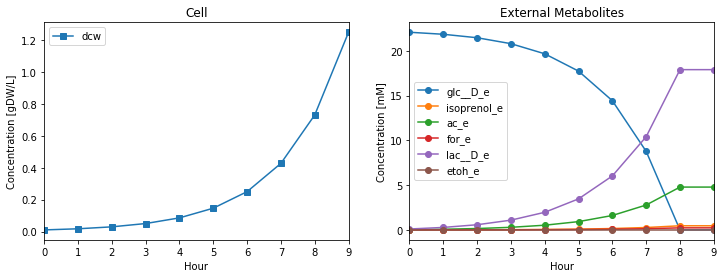

In [12]:
plot_DO_extmets(cell, Emets[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

<font style="color:red">I don't understand what is being demonstrated here. Why the solution is only printed for `CS`?<font/>

We can see that some of the internal fluxes are maxed out the upper bound we established above:

In [13]:
for rxn in ['MDH','PTAr','CS','PPC']:
    print(f"{rxn}: {', '.join([str(solution_TS[i].fluxes['CS']) for i in range(len(solution_TS))])}")

MDH: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
PTAr: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
CS: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
PPC: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


We perform the same calculation for the model with higher isoprenol production that we created above:

In [14]:
solutionHI_TS, modelHI_TS, cellHI, EmetsHI, Erxn2EmetHI = \
    omg.get_flux_time_series(modelHI, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5352266385352652
1.0 optimal 0.5352266385352652
2.0 optimal 0.5352266385352652
3.0 optimal 0.5352266385352652
4.0 optimal 0.5352266385352652
5.0 optimal 0.5352266385352652
6.0 optimal 0.5352266385352652
7.0 optimal 0.5352266385352652
8.0 optimal 0.5352266385352652


In [15]:
EmetsHI

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0708,18.6185,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00330624,0.0287831,0.0013225,0.100218,0
1.0,21.8449,18.488,69.4355,1.99517,1.99983,21.8793,103.7,27.2499,0.00895276,0.0779399,0.0035811,0.271374,0
2.0,21.4592,18.265,69.4156,1.98996,1.99965,21.8752,103.7,27.2498,0.0185961,0.161892,0.00743843,0.563679,0
3.0,20.8004,17.8842,69.3816,1.98107,1.99935,21.8683,103.7,27.2496,0.0350653,0.305267,0.0140261,1.06289,0
4.0,19.6753,17.2338,69.3235,1.96588,1.99883,21.8566,103.7,27.2493,0.0631919,0.550129,0.0252768,1.91546,0
5.0,17.7539,16.123,69.2243,1.93994,1.99793,21.8365,103.7,27.2488,0.111228,0.968313,0.0444911,3.3715,0
6.0,14.4724,14.226,69.0549,1.89565,1.99641,21.8022,103.7,27.2478,0.193265,1.6825,0.0773059,5.85819,0
7.0,8.86817,10.9863,68.7655,1.81999,1.99381,21.7437,103.7,27.2463,0.333371,2.90222,0.133348,10.105,0
8.0,0,5.45333,68.2714,1.69079,1.98936,21.6437,103.7,27.2436,0.572648,4.9853,0.229059,17.358,0
9.0,0,5.45333,68.2714,1.69079,1.98936,21.6437,103.7,27.2436,0.572648,4.9853,0.229059,17.358,0


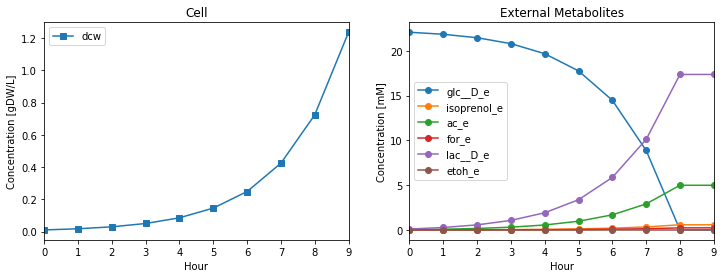

In [16]:
plot_DO_extmets(cellHI, EmetsHI[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

### 3) Getting multiomics data for the wild type strain

We now obtain the multiomics data for each time point:

In [17]:
proteomics_timeseries = {}
transcriptomics_timeseries = {}
metabolomics_timeseries = {}
metabolomics_oldids_timeseries = {}
fluxomics_timeseries = {}
        
# we get the metabolomics_oldids_timeseries to get the old IDs instead if the Pubchem CIDs for importing to Arrowland
# In order to do that we need to pass the old_ids=True parameter and use the returned metabolomics_oldids_timeseries
# to write the files in the next notebook cell as shown below
# if you do not pass the old_ids parameter by default it is False and returns only three dictionaries:
#  proteomics, transcriptomics, metabolomics
for t in tspan:
    fluxomics_timeseries[t] = solution_TS[t].fluxes.to_dict()
    (proteomics_timeseries[t], transcriptomics_timeseries[t], 
     metabolomics_timeseries[t], metabolomics_oldids_timeseries[t]) = omg.get_multiomics(model, 
                                                                                         solution_TS[t], 
                                                                                         user_params['mapping_file'], 
                                                                                         old_ids=True)


### Write the multiomics data, cell concentration and external metabolites concentration data into output files

EDD data output:

In [18]:
# write experiement description file for uploading to EDD
omg.write_experiment_description_file(user_params['output_file_path'], line_name='WT')

# write OD data
omg.write_OD_data(cell, user_params['output_file_path'], line_name='WT')

# write external metablites
omg.write_external_metabolite(Emets, user_params['output_file_path'], linename='WT')

# write omics data
omg.write_omics_files(fluxomics_timeseries, 'fluxomics', user_params, line_name='WT')
omg.write_omics_files(proteomics_timeseries, 'proteomics', user_params, line_name='WT')
omg.write_omics_files(transcriptomics_timeseries, 'transcriptomics', user_params, line_name='WT')
omg.write_omics_files(metabolomics_timeseries, 'metabolomics', user_params, line_name='WT')

Arrowland data output:

In [19]:
# write omics data in separate files for each time point for importing to Arrowland
omg.write_omics_files(fluxomics_timeseries, 'fluxomics', user_params, line_name='WT', al_format=True)
omg.write_omics_files(proteomics_timeseries, 'proteomics', user_params, line_name='WT', al_format=True)
omg.write_omics_files(transcriptomics_timeseries, 'transcriptomics', user_params, line_name='WT', al_format=True)

# writing the old ids for metabolomics (used in Arrowland)
# use the metabolomics_oldids_timeseries dictionary for this
omg.write_omics_files(metabolomics_oldids_timeseries, 'metabolomics', user_params, line_name='WT', al_format=True)

### 4) Getting bioengineered flux profiles through MOMA

First obtain files with suggested designs (i.e. reactions kos and overexpressions):

In [20]:
designs_df = pd.read_csv(f'{user_params["designsfilepath"]}/{user_params["designsfile"]}')


Each design (line) involves the modification of up to 8 fluxes (1 -> keep the same; 2-> double flux, 0-> knock reaction out):

In [21]:
designs_df[:2]

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
0,1,1,1,2,0,2,0,0,0
1,2,1,2,2,2,2,1,1,0


We then use MOMA to calculate flux profiles at each time point for the bioengineered strains. Instead of using the solution time series corresponding to the initial model, we use the solution time series corresponding to the higher production. The reason is that, otherwise, we would never see an increase in isoprenol production, since MOMA minimizes the changes in flux by design. Remember that our goal here is just to create realistic flux profiles that can be used to showcase ART. This approach is good enough: 

In [ ]:
%%time
# reactions names in the dataframe
names = designs_df.columns.drop("Line Name")
solutionsMOMA_TS = {}
if user_params['numinstances'] not in [None, 0]:
    num_strains = user_params['numinstances']
else:
    num_strains = design_df.shape[0]

for i in range(num_strains):
    design = designs_df.iloc[i,:user_params['numreactions']+1]
    if design['Line Name']=='WT':
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solution_TS, grid)
    else:
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solutionHI_TS, grid)

We can check that the knocked out fluxes are zero:

In [ ]:
i = 0
print(designs_df.loc[i,:], '\n')
for rxn in ['CS','PPC','PFL']:
    print(f'{rxn}: {solutionsMOMA_TS[i][5].fluxes[rxn]}')

# Run OMG code to generate synthetic data

In [5]:
%%time
# creating the file path to the model file
filename = os.path.join(omg.MODEL_FILEPATH, omg.MODEL_FILENAME)
omg.generate_data_for_host(filename)

Displaying the reaction bounds after constraining them:
(-10.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-1000.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-200.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-1000.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-1000.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-1000.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-1000.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-200.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-10.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-839.5219917958988, 1000.0)
Displaying the reaction bounds after constraining them:
(-76.73388401633038, 1000.0)
Displaying the reaction bounds after constraining them:
(-1000.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-710.6633672620774, 1000.0)
Displaying 

../OMG/omg.py:254 RuntimeWarning: invalid value encountered in double_scalars


Displaying the reaction bounds after constraining them:
(-14.476803483353784, 1000.0)
Displaying the reaction bounds after constraining them:
(-35.95174307885639, 1000.0)
Displaying the reaction bounds after constraining them:
(-0.8120280420812237, 1000.0)
Displaying the reaction bounds after constraining them:
(-0.540124539348402, 1000.0)
Displaying the reaction bounds after constraining them:
(-11.435539261593966, 1000.0)
Displaying the reaction bounds after constraining them:
(-1.0542687781548568, 1000.0)
Displaying the reaction bounds after constraining them:
(-55.111244447101434, 1000.0)
Displaying the reaction bounds after constraining them:
(-0.0, 1000.0)
Displaying the reaction bounds after constraining them:
(-14.476803483353784, 1000.0)
Displaying the reaction bounds after constraining them:
(-35.95174307885639, 1000.0)
Displaying the reaction bounds after constraining them:
(-0.8120280420812237, 1000.0)
Displaying the reaction bounds after constraining them:
(-0.540124539348

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


-------------------------------------
Isopentenol concentrations:
 0.0    0.000000
1.0    0.003354
2.0    0.012094
3.0    0.034873
4.0    0.094241
5.0    0.248968
6.0    0.774787
7.0    0.774787
8.0    0.774787
9.0    0.774787
dtype: float64
String index: 95
Flux value for isopentenol from MOMA calculation: 90.30121886839387
Isopentenol concentration for this strain: 0.7747865691137857
-------------------------------------
CPU times: user 1h 28min 52s, sys: 38.6 s, total: 1h 29min 30s
Wall time: 1h 29min 42s
